## Read in data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas_datareader.data as web
import graphviz
from Functions import *

% matplotlib inline
Psize = (30,20)

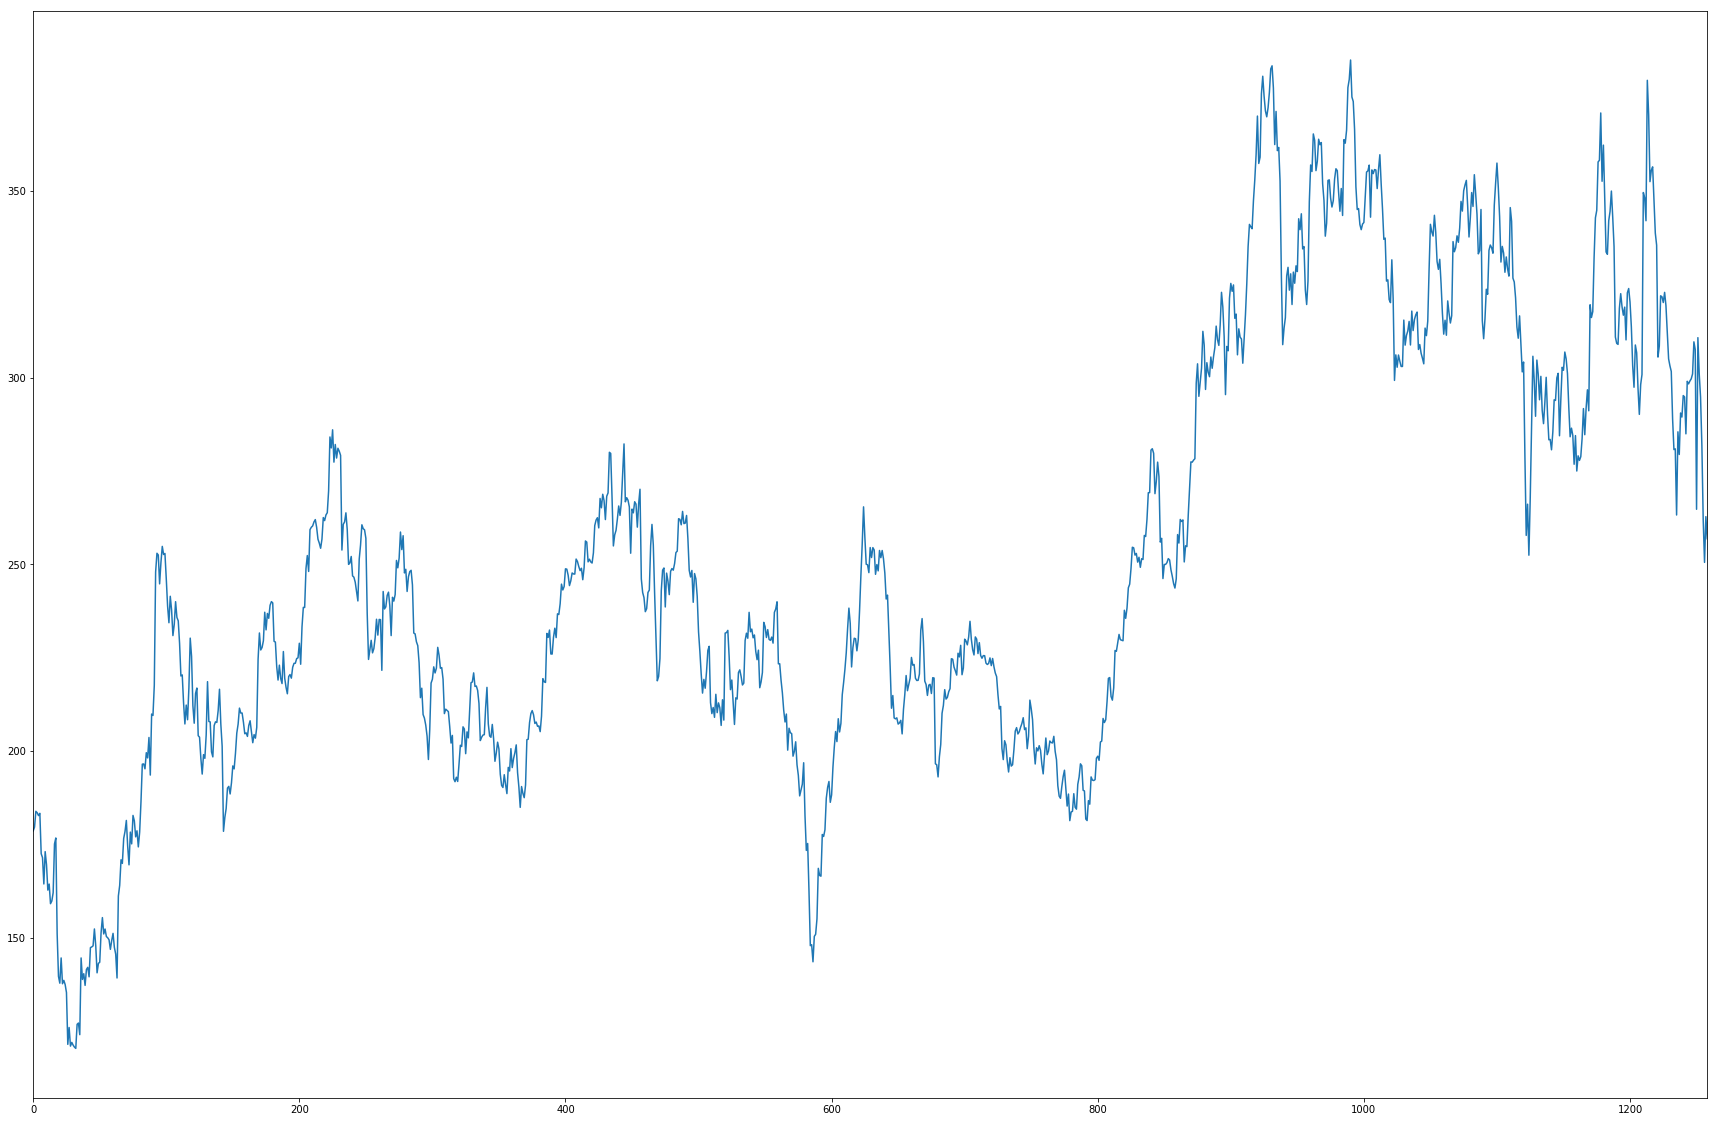

In [2]:
tsla_full = pd.read_csv('Data/TSLA.csv')
price = tsla_full['Close'].dropna().reset_index(drop = True)
price.plot(figsize = Psize);

The natural ROI throughout the period is 0.4374930571487362,     total ROI if following every buy and sell signal is 0.6811228360624053. Total loss prevention is 0.8181064472565434.    0.4375 of buys are successful while 0.3958333333333333 of sells are successful. Maximum percentage gain per trade is 0.37776577615240686 while maximum percentage loss per trade is -0.14507094785443067


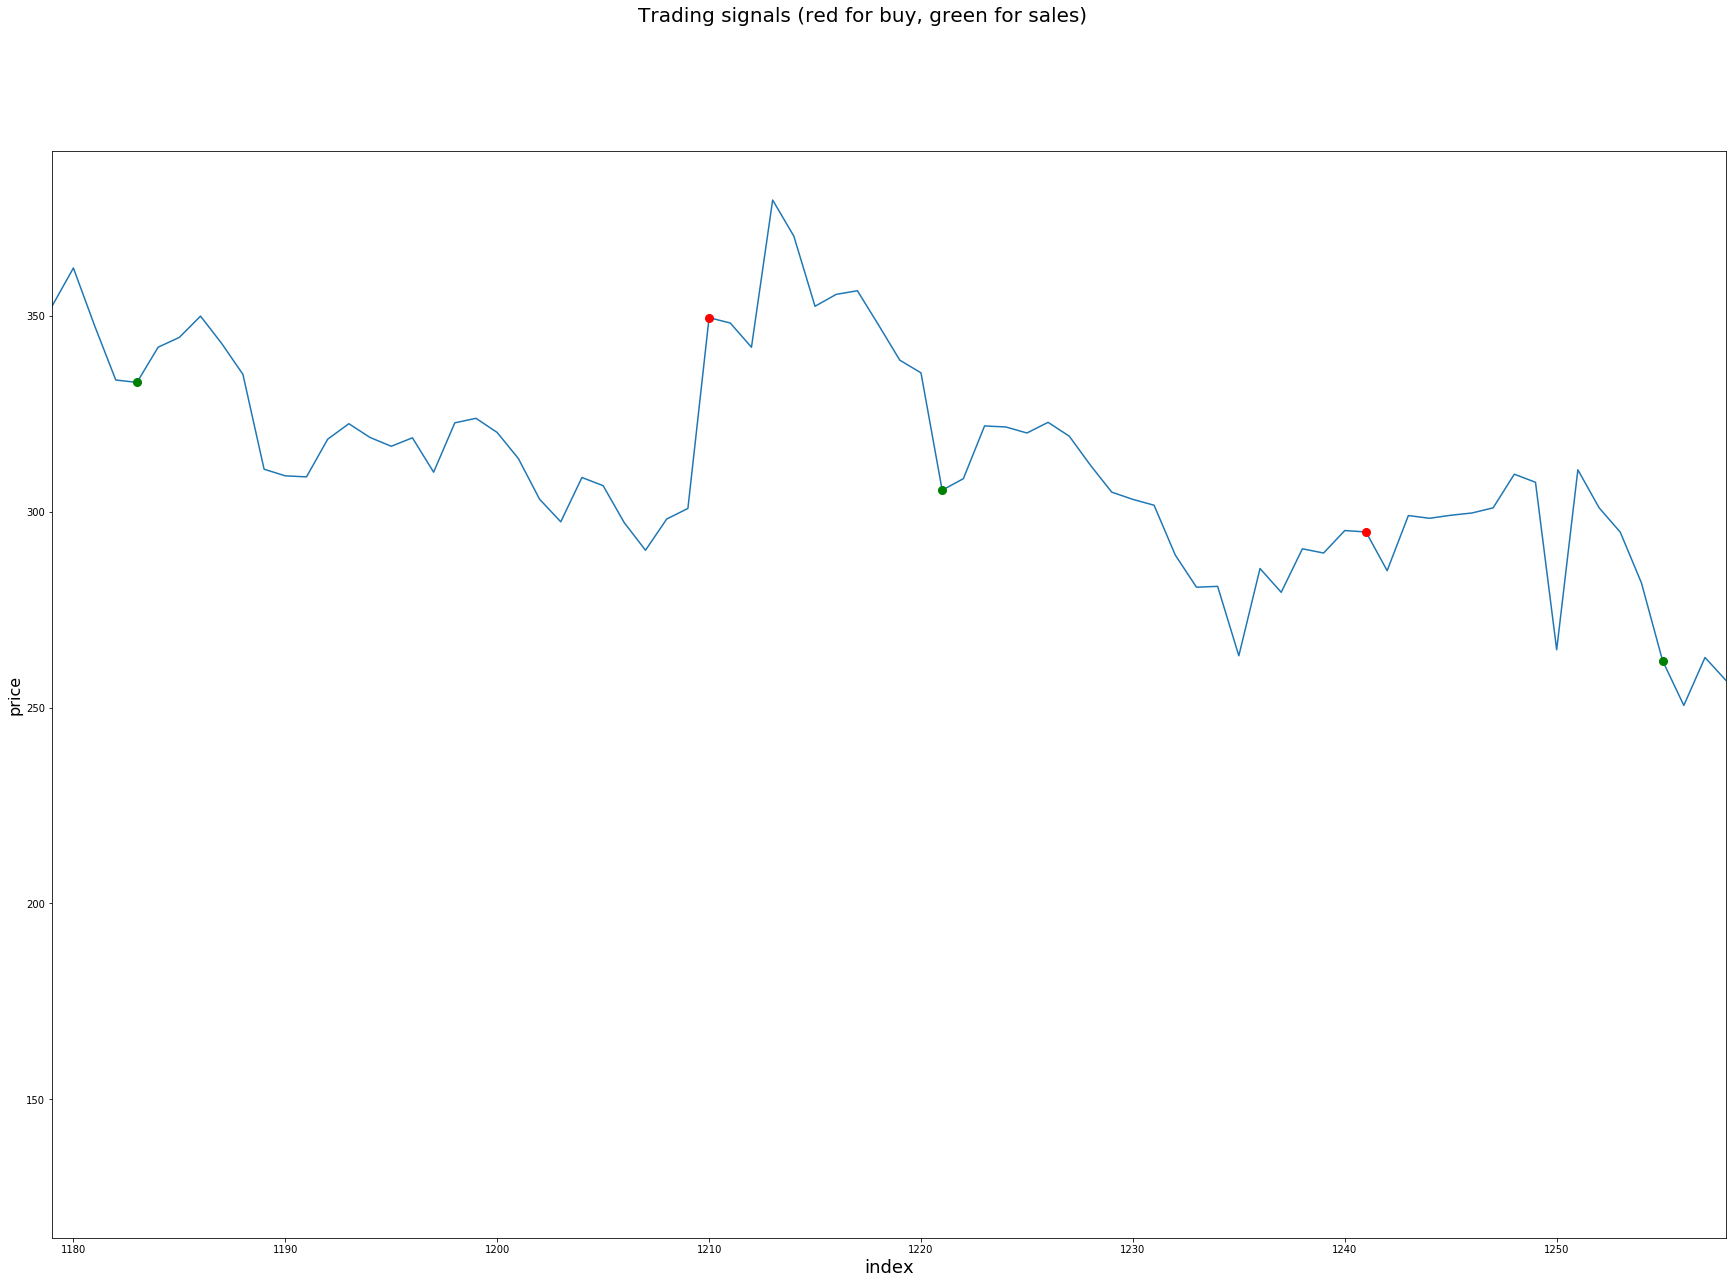

In [3]:
from Functions import *
tesla_sum = get_rich(price,day_num=80)

We will look at price of tesla from 2014/01/01 to 2017/12/31

### MACD

In [5]:
"""
Calculate the exponential moving average
"""
price_ema_12 = price.ewm(span = 12,adjust = False).mean()

price_ema_26 = price.ewm(span = 26, adjust = False).mean()

I tested that the calculation above is the same as described in the Udemy slides with the formula below:

![title](picture/formula.png)

Just to make sure that the ema calculated above is independent of future data, we did the calculation below to check:

In [7]:
sum(price_ema_12[:100] != price[:100].ewm(span = 12, adjust = False).mean())

0

From above we can see that the calculation of exponentially weighted MA is independent of future data

In [ ]:
pd.DataFrame({'price':price,'ema_12':price_ema_12,'ema_26':price_ema_26}).plot(figsize = Psize)

In [ ]:
macd = np.array(price_ema_12) - np.array(price_ema_26)

signal = pd.ewma(macd,span = 9, adjust = False)

In [ ]:
pd.DataFrame({'macd':macd,'signal':signal}).plot(figsize = Psize)

Moving average convergence divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of prices. The MACD is calculated by subtracting the 26-day exponential moving average (EMA) from the 12-day EMA. A nine-day EMA of the MACD, called the "signal line", is then plotted on top of the MACD, functioning as a trigger for buy and sell signals.

Moving average convergence divergence (MACD) indicators can be interpreted using three different methods:

1. Crossovers - As shown in the chart above, when the MACD falls below the signal line, it is a bearish signal, which indicates that it may be time to sell. Conversely, when the MACD rises above the signal line, the indicator gives a bullish signal, which suggests that the price of the asset is likely to experience upward momentum. Many traders wait for a confirmed cross above the signal line before entering into a position to avoid getting "faked out" or entering into a position too early, as shown by the first arrow.

2. Divergence - When the security price diverges from the MACD, it signals the end of the current trend. For example, a stock price that is rising and a MACD indicator that is falling could mean that the rally is about to end. Conversely, if a stock price is falling and the MACD is rising, it could mean that a bullish reversal could occur in the near-term. Traders often use divergence in conjunction with other technical indicators to find opportunities.

3. Dramatic Rise - When the MACD rises dramatically - that is, the shorter moving average pulls away from the longer-term moving average - it is a signal that the security is overbought and will soon return to normal levels. Traders will often combine this analysis with the Relative Strength Index (RSI) or other technical indicators to verify overbought or oversold conditions.

Traders also watch for a move above or below the zero line because this signals the position of the short-term average relative to the long-term average. When the MACD is above zero, the short-term average is above the long-term average, which signals upward momentum. The opposite is true when the MACD is below zero. As you can see from the chart above, the zero line often acts as an area of support and resistance for the indicator.

source: https://www.investopedia.com/terms/m/macd.asp

In [ ]:
"""
define a function to capture crossovers
"""

def get_cross_overs(short,long):
    """
    Get cross-ovrers from two curves
    
    ---Parameters
    
    short: the curve that fluctuates more. i.e. a smoothed curve with lower window
    
    long: the curve that fluctuates less. i.e. a smoothed curve with longer window
    
    ---Returns
    
    dictionary containing buy or sell index calculated with the crossovers from the curve
    
    
    """

    assert(len(short) == len(long))    
    
    buy_idx = [i for i in list(range(1,len(short))) if ((short[i-1] < long[i-1]) & (short[i] > long[i]))]
    
    sell_idx = [i for i in list(range(1,len(short))) if ((short[i-1] > long[i-1]) & (short[i] < long[i]))]
    
    return {'buy':buy_idx,'sell':sell_idx}


In [ ]:
"""
define a function to plot the trading signals
"""

def plot_trade_sig(vec,short,long,max_day = 'max'):
    
    """
    Plot the trading signals
    
    ---Paramters
    
    vec: the stock price
    
    short/long: same as described in the function 'get_corss_overs'
    
    ---Returns
    dictionary containing buy or sell index calculated with the crossovers from the curve
    """
    import numpy as np
    
    if max_day == 'max':
        max_day = len(vec)
    
    co  = get_cross_overs(short,long)
    
    normalizedVec = (np.array(vec) - min(vec))/(max(vec) - min(vec))
    
    vec[-max_day:].plot(figsize = Psize,title = 'Trading signals (red for buy, green for sales)')
    
    for idx in list(co['sell'])[-max_day:]:
        plt.axvline(idx,ymin = normalizedVec[idx] - 0.1, color = 'g',\
                ymax = normalizedVec[idx] + 0.1)
    
    for idx in co['buy'][-max_day:]:
        plt.axvline(idx,ymin = normalizedVec[idx] - 0.1, color = 'r',\
                ymax = normalizedVec[idx] + 0.1)
        
    return co

Now that we see the trading signal generated by MACD and signal curve, we need to comeup with a measurement of performance. Keep in mind of the fact that buy and sell signals generated by crossovers always show a toggling pattern (they happend one after another. It is impossible to see more than one buy/sell signals in a row), we can define performance as follows:

* For each buy signal, we will look at the amonut we gain from that buy with the percentage difference comparing with the price at next sell.

* For each sell signal, we will look at the loss-amount we prevented from that sell with the percentage difference compring with the price at next buy

In [ ]:
"""
Define a function to measure the performance of the model
"""

def get_performance(price, buy_idx, sell_idx):
    
    """
    Get the performance of a set of buying and selling signals
    
    ---Parameter
    
    price: the price of a certain stock where the buying and selling signals are derived from
    
    buy_idx: the buying index
    
    sell_idx: the selling index
    
    ---Return
    
    all_gains: percentage gains from each buy and sell pairs
    
    all_loss_prevent: percentage loss prevented from each sell and buy pairs
    
    roi: Return of investment in decimal percentage
    
    tot_lossPrev: Percentage of total loss prevented from sell signals
    
    messge: a summarizing message of the performance
    """
    
    import numpy as np
    #' First make sure the buy and sell signals are of the same length, starting with a buy signal and ending with a sell signal
    
    if min(buy_idx) > min(sell_idx):
        sell_idx = sell_idx[1:]
        
    if max(buy_idx) > max(sell_idx):
        buy_idx = buy_idx[:-1]
        
    assert(len(buy_idx) == len(sell_idx))
    
    # Calculate buy gains
    buy_price = price[buy_idx]
    sell_price = price[sell_idx]
    
    from functools import reduce
    percent_gains = (np.array(sell_price) - np.array(buy_price))/np.array(buy_price)
    total_gain = reduce(lambda x, y: x*y, (percent_gains + 1))
    
    roi = total_gain - 1
    
    # Calculate sell loss prevention
    buy_price_sub = buy_price[1:]
    sell_price_sub = sell_price[:-1]
    
    percent_loss_prevent = (np.array(sell_price_sub) - np.array(buy_price_sub))/np.array(sell_price_sub)
    total_loss_prevents =  reduce(lambda x, y: x*y, (1 + percent_loss_prevent))
    
    msg = "The natural ROI throughout the period is {}, \
    total ROI if following every buy and sell signal is {}. Total loss prevention is {}.\
    {} of buys are successful while {} of sells are successful. Maximum percentage gain per trade is {} while maximum percentage loss per trade is {}".format((list(price)[-1]-price[0])/price[0], roi, total_loss_prevents, sum(percent_gains > 0)/len(buy_idx),
                                                                        sum(percent_loss_prevent > 0)/len(sell_idx), max(percent_gains),min(percent_gains))
    
    print(msg)
    
    class out:
        
        all_gains = percent_gains
        all_loss_prevent = percent_loss_prevent
        
        roi_num = roi
        tot_lossPrev = total_loss_prevents
        
        message = msg
    
    return out

In [ ]:
macd_sig_performance = get_performance(price,macd_sig['buy'],macd_sig['sell'])

The second signal we are plotting is the Double SMA Crossover Signal

In [ ]:
sma5 = price.rolling(window = 5, min_periods=0,center = False).mean()
sma20 =  price.rolling(window = 20, min_periods=0,center = False).mean()

In [ ]:
pd.DataFrame({'sma5':sma5,'sma20':sma20}).plot(figsize = Psize)

In [ ]:
sma_co = plot_trade_sig(price,macd,signal)

In [ ]:
sma_co_performance = get_performance(price,sma_co['buy'],sma_co['sell'])

It seems that it is exactly the same as the MACD/signal crossover

The concerning factor is that only 44% of the buy signal results in a gain. It is known that the MACD signals are bad for short term indications. I wonder if we can develop a metric that can calulate the "confidence" of each buy signal. Also, is it possible to develop a calculation for loss prevention? The key idea behind this calcuation is that, it is possible that if after a buy, the asset shrinks by a certain percentage, then this buy signal is likely to be bad.

We start by defining a function that takes in price, buy and sell signals and derives the following:

* Min price before selling

* Day since last sell

* Whether each buy signal is a gain

In [ ]:
def get_confidence_info(price, buy_idx, sell_idx):
    
    """
    Get information about how confidence should we be for each buy signal
    
    ---Parameters:
    
    same as get_performance function
    
    ---Return:
    
    gains: a vector of gains for each buy and sell combination
    
    min_since_purchase: minimum price since the most recent purchase, before the next sell
    
    percent_loss_since_purchase: percentage of the min_since_purchase
    
    day_since_last_sells: number of days between a buy signal and the sell signal before it
    """
    
    import numpy as np
    #' First make sure the buy and sell signals are of the same length, starting with a buy signal and ending with a sell signal
    
    if min(buy_idx) > min(sell_idx):
        sell_idx = sell_idx[1:]
        
    if max(buy_idx) > max(sell_idx):
        buy_idx = buy_idx[:-1]
        
    assert(len(buy_idx) == len(sell_idx))
    
    # Calculate buy gains
    buy_price = price[buy_idx]
    sell_price = price[sell_idx]
    percent_gains = (np.array(sell_price) - np.array(buy_price))/np.array(buy_price)
    
    min_since_buy = []
    day_since_last_sell = []
    
    for i in list(range(len(buy_idx))):
        
        price_vec = price[(buy_idx[i] + 1):sell_idx[i]]
        
        if len(price_vec) == 0:
            min_since_buy.append(min([price[buy_idx[i]],price[sell_idx[i]]]))
        else:
            min_since_buy.append(min(price_vec))
        
        if i == 0:
            day_since_last_sell.append(-1)
        else:
            day_since_last_sell.append(buy_idx[i] - sell_idx[i-1])
            
    percent_loss_since_buy = (np.array(min_since_buy) - np.array(price[buy_idx]))/np.array(price[buy_idx])
    
    class out:
        
        gains = percent_gains
        
        min_since_purchase = min_since_buy
        
        percent_loss_since_purchase = percent_loss_since_buy
        
        day_since_last_sells = day_since_last_sell
    
    return out

In [ ]:
bp_stats = get_confidence_info(price, macd_sig['buy'],macd_sig['sell'])

In [ ]:
ps = pd.DataFrame({"gain":bp_stats.gains,"day_since_sell":bp_stats.day_since_last_sells,"max_loss":bp_stats.percent_loss_since_purchase})

ps = ps.loc[ps['day_since_sell'] > 0].reset_index(drop = True)

ps['gain_flag'] = (ps['gain'] > 0).astype(int)

Let's fit a decision tree to see the if there is a rule that can help prevent loss

In [ ]:
"""
First encode the response variable
"""

# Get rid of the first observation as we don't have "day since sell" info
"""
training - testing split
"""
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ps[['day_since_sell','max_loss']], ps['gain_flag'], test_size = 0.2,random_state = 23)

X_train.reset_index(drop = True,inplace = True)
X_test.reset_index(drop = True,inplace = True)
y_train.reset_index(drop = True,inplace = True)
y_test.reset_index(drop = True,inplace = True)

"""
Desicion Tree
"""
from sklearn import tree
cart = tree.DecisionTreeClassifier(max_depth=1)
cart_f = cart.fit(X_train,y_train)

pred_cart_f = cart_f.predict(X_test)

from sklearn.metrics import confusion_matrix
from Functions import *

sklCM_cart = confusion_matrix(y_pred=pred_cart_f, y_true=y_test)

plot_confusion_matrix(sklCM_cart,target_names = ['gain','loss'])

In [ ]:
cart_plot = tree.export_graphviz(cart_f, out_file=None,feature_names = ['day_since_sell','max_loss']) 
graph = graphviz.Source(cart_plot) 
graph

The classification results are bad. Given the amound of data, it is hard to train a nice model. However, this is not as bad as it seems like as our goal is not to classify whether it is a good buy, but rather to come-up with a stop limit for each purchase

In [ ]:
cart = tree.DecisionTreeClassifier(max_depth=2)
cart_full = cart.fit(ps[['day_since_sell','max_loss']],ps['gain_flag'])

In [ ]:
import graphviz

cart_plot = tree.export_graphviz(cart_full, out_file=None,feature_names = ['day_since_sell','max_loss']) 
graph = graphviz.Source(cart_plot) 
graph

Looking at the splite for decision tree above, we can translate the first node into the following info:

1. After a buy, if we accumulate more than 2.6% loss before the next sell signal, then there is a 87% chance that this buy will result in a loss. 

2. After a buy, if we accumulate less than 2.6% loss before the next sell signal, then there is a 75% chance that this buy will result in a gain.

Finally, we will want to implement this strategy and dynamically calculate the probability of gain/loss and set a stop loss limit base on the probability of a certain order being good/bad. To have a quick examination of what could be the improvement following the strategy above, we will implement a simple if-else case following the first node above

then our strategy now will be to follow the signals with a stop loss limit of 1%. In this way, we can calculate a new set of returns with this specific strategy:


In [ ]:
ps['new_gain'] = ps['gain']
ps['new_gain'][(ps['max_loss']<=-0.026)] = -0.026

In [ ]:
ps.head()

In [ ]:
from functools import reduce
reduce(lambda x, y: x*y, (ps['new_gain'] + 1))

Now it appears to be higher than the natural gain.

Since Tesla is a stock that has a positive gain in the past 3 years, this strategy seem to have a good return. How about a stock that is fluctuating?

Before we experiment on other stocks, lets first define a function that does the following:

input: Historical stock price

output:

1. Buy/sell signals calculated with macd

2. signal plot and performance 

3. Full plot for decisiontree

In [ ]:
def get_rich(price_full,day_num = 'max'):
    
    """
    One function to get all summaries around MACD/Signal line crossing signals
    """
       
    import numpy as np
    #Calculate the exponential moving average
    
    price_ema_12 = pd.ewma(price,span = 12,adjust = False)
    price_ema_26 = pd.ewma(price,span = 26, adjust = False)
    
    #Calculate MACD and signal line
    macd = np.array(price_ema_12) - np.array(price_ema_26)
    signal = pd.ewma(macd,span = 9, adjust = False)
    
    # Get buy/sell indexes
    idxes = get_cross_overs(short = macd, long = signal)
    buy = idxes['buy']
    sell = idxes['sell']
    
    # Plot trade signals
    plot_trade_sig(price,macd,signal,max_day = day_num)
    
    # Get performances
    perf = get_performance(price = price, buy_idx = buy, sell_idx = sell)
    
    # Get confidence info
    conf = get_confidence_info(price = price, buy_idx = buy, sell_idx = sell)
    
    # Construct data frame with confidence info
    ps = pd.DataFrame({"gain":conf.gains,"day_since_sell":conf.day_since_last_sells,"max_loss":conf.percent_loss_since_purchase})
    ps = ps.loc[ps['day_since_sell'] > 0].reset_index(drop = True)
    ps['gain_flag'] = (ps['gain'] > 0).astype(int)
    
    # Get the decision tree
    from sklearn import tree
    import graphviz
    cart = tree.DecisionTreeClassifier(max_depth=2)
    cart_full = cart.fit(ps[['day_since_sell','max_loss']],ps['gain_flag'])
    
    cart_plot = tree.export_graphviz(cart_full, out_file=None,feature_names = ['day_since_sell','max_loss']) 
    graph = graphviz.Source(cart_plot)
    
    class out:
        
        calculated_macd = macd
        calculated_signal = signal
        buy_idxes = buy
        sell_idxes = sell
        performance = perf
        confidence_info = conf
        confidence_table = ps
        cart_graph = graph
    
    return out

## Tesla

In [ ]:
from Functions import *
tesla_sum = get_rich(price)

## Baidu

In [ ]:
"""
Now we read in price for baidu
"""

baidu_df = pd.read_csv('Data/BIDU.csv')
bidu = baidu_df['Close']

In [ ]:
bidu_overall = get_rich(bidu)

In [ ]:
bidu_overall.cart_graph

## UVXY

In [ ]:
uvxy_df = pd.read_csv('Data/UVXY.csv')
uvxy = uvxy_df['Close']
uvxy_perf = get_rich(uvxy)

In [ ]:
uvxy_perf.cart_graph

## IBM

In [ ]:
ibm_df = pd.read_csv('Data/IBM.csv')
ibm = ibm_df['Close']

In [ ]:
ibm_summary = get_rich(ibm)

In [ ]:
ibm_summary.cart_graph

In [ ]:
ibm_ps = ibm_summary.confidence_table
ibm_ps['new_gain'] = ibm_ps['gain']
ibm_ps['new_gain'][ibm_ps['gain'] <= 0] = 0
reduce(lambda x, y: x*y, (ibm_ps['new_gain'] + 1)) - 1

## FB

In [ ]:
fb_df = pd.read_csv('Data/FB.csv')
fb = fb_df['Close']

In [ ]:
fb_summary = get_rich(fb)

In [ ]:
fb_summary.cart_graph

In [ ]:
ps = fb_summary.confidence_table
ps['new_gain'] = ps['gain']
ps['new_gain'][ps['gain'] <= 0] = 0
reduce(lambda x, y: x*y, (ps['new_gain'] + 1)) - 1

In [ ]:
ps

In [10]:
import quandl
import datetime as dt
today=dt.date.today()
thirty_days=dt.timedelta(days=30)
thirty_days_ago=today-thirty_days
data = quandl.get("WIKI/AAPL", start_date=str(thirty_days_ago), end_date=str(today),column_index=4)

In [15]:
quandl.ApiConfig.api_key = 'N1bz1rd7GtQXhuVmn6ka'

tb = quandl.get_table('WIKI/PRICES',ticker =  'AAPL')

(9400, 14)